In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from matplotlib.ticker import AutoMinorLocator
import matplotlib.patches as patches

In [2]:
# fpath = "/fast_scratch/QVAE/syn_data/dataset2_synthetic_macabre-candle-1372v2.hdf5"

# fpath = "/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_2_synthetic_uncond_enc.hdf5" #/fast_scratch/QVAE/data/atlas_dataset2and3_uniform/dataset_2_synthetic.hdf5" #"/fast_scratch/QVAE/syn_data/dataset2_synthetic_nohits.hdf5" #"/fast_scratch/QVAE/syn_data/dataset2_synthetic.hdf5"

# fpath = "/fast_scratch/QVAE/syn_data/wise-tree-1429.hdf5"

fpath = "/fast_scratch_1/caloqvae/syn_data/dataset2_synthetic_denim-smoke-166en130.hdf5"
in_data=h5py.File(fpath,'r')

atlas_fpath = "/fast_scratch_1/caloqvae/test_data/dataset_2_2.hdf5"  #"/fast_scratch/QVAE/data/atlas_dataset2and3_uniform/dataset_2_1.hdf5"  
atlas_data=h5py.File(atlas_fpath,'r')

test_fpath = "/fast_scratch_1/caloqvae/test_data/dataset_2_2.hdf5"
test_data=h5py.File(atlas_fpath,'r')

In [3]:
print(in_data.keys())

<KeysViewHDF5 ['incidence energy', 'showers']>


In [4]:
low_cutoff = 0
high_cutoff = 2000

In [5]:
# atlas_energies = np.array(atlas_data["incident_energies"])/1000
# data_energies = np.array(in_data['incident_energies'])/1000 #loaded['energy']/1000 

atlas_energies = np.array(atlas_data["incident_energies"])/1000
data_energies = np.array(in_data['incidence energy'])/1000 #loaded['energy']/1000 


In [6]:
atlas_data = np.array(atlas_data["showers"]) #[((low_cutoff < atlas_energies) & (atlas_energies < high_cutoff)).squeeze()]
data = np.array(in_data['showers']) #[((low_cutoff < data_energies) & (data_energies < high_cutoff)).squeeze()] 

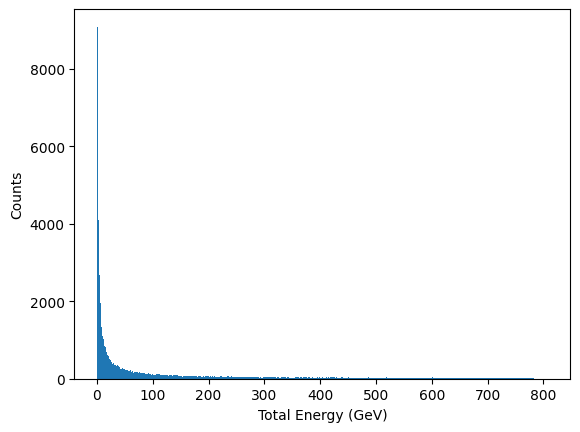

In [7]:
plt.hist(atlas_data.sum(axis=1) / 1000 , log=False, bins=1000);
plt.xlabel("Total Energy (GeV)");
plt.ylabel("Counts");

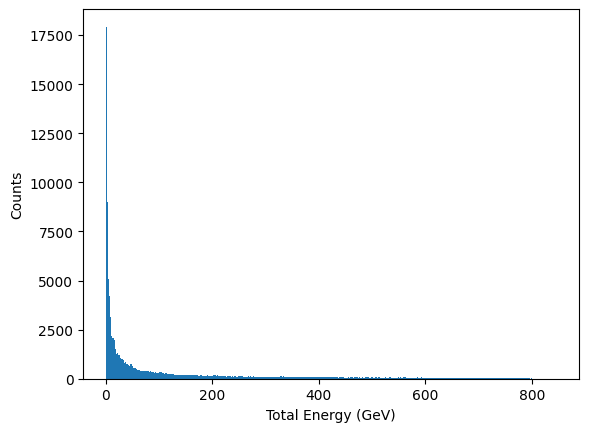

In [8]:
counts = plt.hist(data.sum(axis=1) / 1000 , log=False, bins=400);
plt.xlabel("Total Energy (GeV)");
plt.ylabel("Counts");

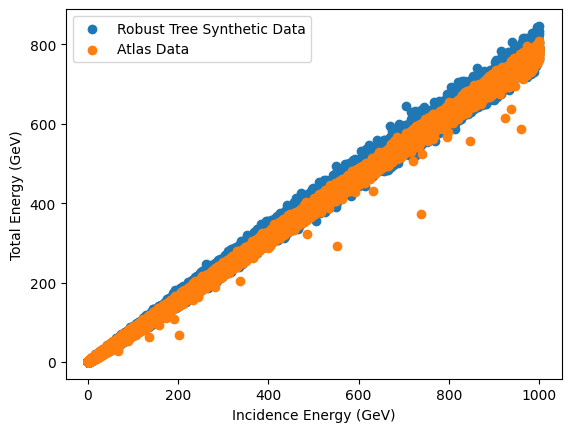

In [9]:
plt.scatter(data_energies, data.sum(axis=1) / 1000, label="Robust Tree Synthetic Data")
plt.scatter(atlas_energies, atlas_data.sum(axis=1) / 1000, label="Atlas Data")
plt.ylabel("Total Energy (GeV)");
plt.xlabel("Incidence Energy (GeV)");
plt.legend();

In [10]:

print(atlas_data.shape)
print(data.shape)

(100000, 6480)
(100000, 6480)


In [11]:
data = (data).mean(axis=0)
atlas_data = (atlas_data).mean(axis=0)

In [12]:
data = np.reshape(data, (45,16,9))
atlas_data = np.reshape(atlas_data, (45,16,9))

In [13]:
data.shape
atlas_data.shape

(45, 16, 9)

In [14]:
r_avg_data = data.sum(axis=0).sum(axis=0) /1000
r_avg_atlas_data = atlas_data.sum(axis=0).sum(axis=0) /1000

theta_avg_data = data.sum(axis=0).sum(axis=1) /1000
theta_avg_atlas_data = atlas_data.sum(axis=0).sum(axis=1) /1000

layer_avg_data = data.sum(axis=1).sum(axis=1) /1000
layer_avg_atlas_data = atlas_data.sum(axis=1).sum(axis=1) /1000

In [15]:
print("r-bin average arrays")
print(r_avg_data.shape)
print(r_avg_atlas_data.shape)

print("theta-bin average arrays")
print(theta_avg_data.shape)
print(theta_avg_atlas_data.shape)

print("layer-bin average arrays")
print(layer_avg_data.shape)
print(layer_avg_atlas_data.shape)

r-bin average arrays
(9,)
(9,)
theta-bin average arrays
(16,)
(16,)
layer-bin average arrays
(45,)
(45,)


In [22]:
import HighLevelFeatures.py as HLF

def extract_shower_and_energy(given_file, which):
    """ reads .hdf5 file and returns samples and their energy """
    print("Extracting showers from {} file ...".format(which))
    shower = given_file['showers'][:]
    energy = given_file['incident_energies'][:]
    print("Extracting showers from {} file: DONE.\n".format(which))
    return shower, energy

def prepare_high_data_for_classifier(hdf5_file, hlf_class, label):
    """ takes hdf5_file, extracts high-level features, appends label, returns array """
    voxel, E_inc = extract_shower_and_energy(hdf5_file, label)
    E_tot = hlf_class.GetEtot()
    E_layer = []
    for layer_id in hlf_class.GetElayers():
        E_layer.append(hlf_class.GetElayers()[layer_id].reshape(-1, 1))
    EC_etas = []
    EC_phis = []
    Width_etas = []
    Width_phis = []
    for layer_id in hlf_class.layersBinnedInAlpha:
        EC_etas.append(hlf_class.GetECEtas()[layer_id].reshape(-1, 1))
        EC_phis.append(hlf_class.GetECPhis()[layer_id].reshape(-1, 1))
        Width_etas.append(hlf_class.GetWidthEtas()[layer_id].reshape(-1, 1))
        Width_phis.append(hlf_class.GetWidthPhis()[layer_id].reshape(-1, 1))
    E_layer = np.concatenate(E_layer, axis=1)
    EC_etas = np.concatenate(EC_etas, axis=1)
    EC_phis = np.concatenate(EC_phis, axis=1)
    Width_etas = np.concatenate(Width_etas, axis=1)
    Width_phis = np.concatenate(Width_phis, axis=1)
    ret = np.concatenate([np.log10(E_inc), np.log10(E_layer+1e-8), EC_etas/1e2, EC_phis/1e2,
                          Width_etas/1e2, Width_phis/1e2, label*np.ones_like(E_inc)], axis=1)
    return ret

ModuleNotFoundError: No module named 'HighLevelFeatures'

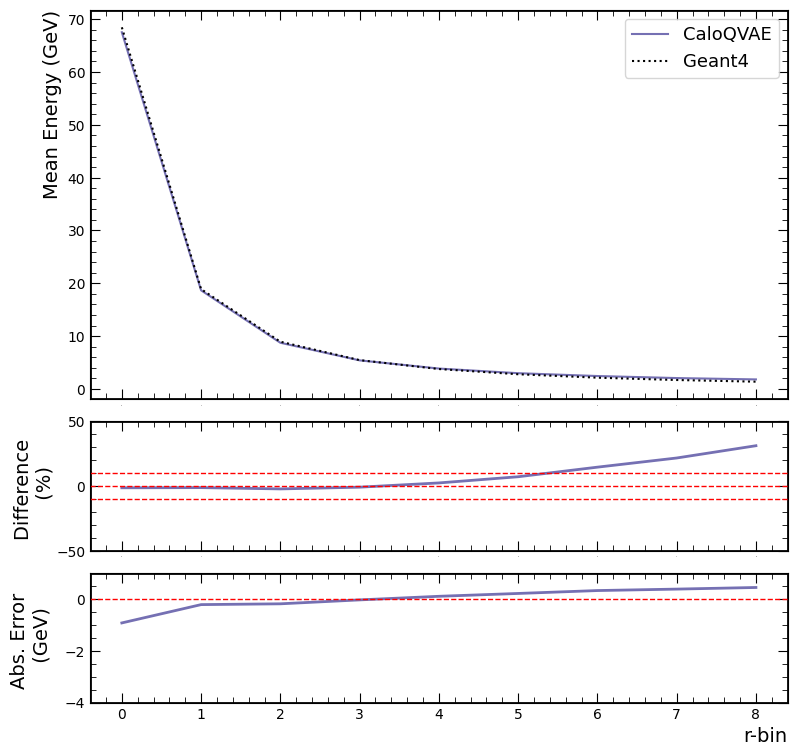

In [16]:
fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(3, 1, height_ratios=[3,1,1]) 
gs.update(wspace=0.025, hspace=0.1)

ax0 = plt.subplot(gs[0])
plt.xticks(fontsize=0)
ax1 = plt.subplot(gs[1],sharex=ax0)
plt.xticks(fontsize=0)
ax2 = plt.subplot(gs[2],sharex=ax0)

plot_label = 'CaloQVAE'
atlas_label = 'Geant4'

ax0.plot(r_avg_data,label=plot_label,linestyle='-',color='#7570b3')
ax0.plot(r_avg_atlas_data,label=atlas_label,linestyle='dotted',color='black')

ratio = 100*np.divide(r_avg_data-r_avg_atlas_data,r_avg_atlas_data)
ax1.plot(ratio,color='#7570b3',linewidth=2,linestyle='-')
ax2.plot(r_avg_data-r_avg_atlas_data,color='#7570b3',linewidth=2,linestyle='-')

ax0.set_xlabel("",fontsize=20)
ax0.set_ylabel("Mean Energy (GeV)", fontsize=14, loc="top")

ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())

ax0.tick_params(which='both', direction="in")
ax0.tick_params(which='major', length=7, direction="in")
ax0.tick_params(which='minor', length=4, direction="in")

ax0.xaxis.set_ticks_position('both')
ax0.yaxis.set_ticks_position('both')
ax0.tick_params(axis="x",direction="in")
ax0.tick_params(axis="y",direction="in")

# Get the axis limits
x_min, x_max = ax0.get_xlim()
y_min, y_max = ax0.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax0.add_patch(outer_rectangle)

ax0.legend(loc='best',fontsize=13,ncol=1)

ax1.set_ylabel('Difference \n (%)', fontsize=14, labelpad=1)
plt.xlabel("r-bin", fontsize=14, loc='right')
ax1.axhline(y=0.0, color='r', linestyle='--',linewidth=1)
ax1.axhline(y=10, color='r', linestyle='--',linewidth=1)
ax1.axhline(y=-10, color='r', linestyle='--',linewidth=1)
ax1.set_ylim([-50,50])
plt.rc("font", size=13)

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', direction="in")
ax1.tick_params(which='major', length=7, direction="in")
ax1.tick_params(which='minor', length=4, direction="in")

ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.tick_params(axis="x",direction="in")
ax1.tick_params(axis="y",direction="in")

# Get the axis limits
x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax1.add_patch(outer_rectangle)

# Axis 2

ax2.set_ylabel('Abs. Error \n (GeV)', fontsize=14, labelpad=10)
ax2.axhline(y=0.0, color='r', linestyle='--',linewidth=1)
ax2.set_ylim([-4,1])

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax2.tick_params(which='both', direction="in")
ax2.tick_params(which='major', length=7, direction="in")
ax2.tick_params(which='minor', length=4, direction="in")

ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
ax2.tick_params(axis="x",direction="in")
ax2.tick_params(axis="y",direction="in")

# Get the axis limits
x_min, x_max = ax2.get_xlim()
y_min, y_max = ax2.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax2.add_patch(outer_rectangle)

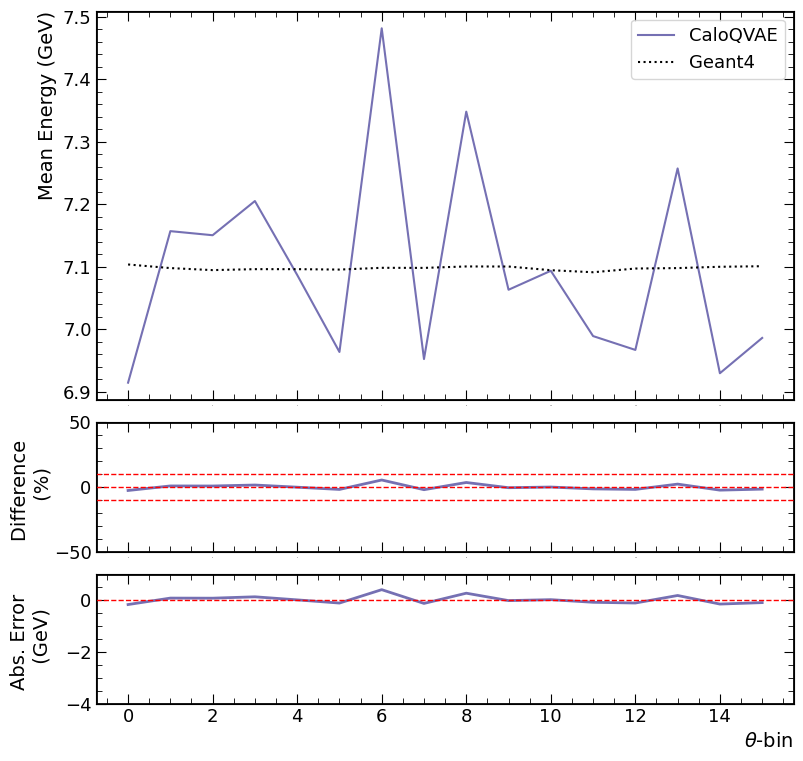

In [17]:
fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(3, 1, height_ratios=[3,1,1]) 
gs.update(wspace=0.025, hspace=0.1)

ax0 = plt.subplot(gs[0])
plt.xticks(fontsize=0)
ax1 = plt.subplot(gs[1],sharex=ax0)
plt.xticks(fontsize=0)
ax2 = plt.subplot(gs[2],sharex=ax0)

plot_label = 'CaloQVAE'
atlas_label = 'Geant4'

ax0.plot(theta_avg_data,label=plot_label,linestyle='-',color='#7570b3')
ax0.plot(theta_avg_atlas_data,label=atlas_label,linestyle='dotted',color='black')

ratio = 100*np.divide(theta_avg_data-theta_avg_atlas_data,theta_avg_atlas_data)
ax1.plot(ratio,color='#7570b3',linewidth=2,linestyle='-')
ax2.plot(theta_avg_data-theta_avg_atlas_data,color='#7570b3',linewidth=2,linestyle='-')

ax0.set_xlabel("",fontsize=20)
ax0.set_ylabel("Mean Energy (GeV)", fontsize=14, loc="top")

ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())

ax0.tick_params(which='both', direction="in")
ax0.tick_params(which='major', length=7, direction="in")
ax0.tick_params(which='minor', length=4, direction="in")

ax0.xaxis.set_ticks_position('both')
ax0.yaxis.set_ticks_position('both')
ax0.tick_params(axis="x",direction="in")
ax0.tick_params(axis="y",direction="in")

# Get the axis limits
x_min, x_max = ax0.get_xlim()
y_min, y_max = ax0.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax0.add_patch(outer_rectangle)

ax0.legend(loc='best',fontsize=13,ncol=1)

ax1.set_ylabel('Difference \n (%)', fontsize=14, labelpad=1)
plt.xlabel(r'$\theta$-bin', fontsize=14, loc='right')
ax1.axhline(y=0.0, color='r', linestyle='--',linewidth=1)
ax1.axhline(y=10, color='r', linestyle='--',linewidth=1)
ax1.axhline(y=-10, color='r', linestyle='--',linewidth=1)
ax1.set_ylim([-50,50])
plt.rc("font", size=13)

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', direction="in")
ax1.tick_params(which='major', length=7, direction="in")
ax1.tick_params(which='minor', length=4, direction="in")

ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.tick_params(axis="x",direction="in")
ax1.tick_params(axis="y",direction="in")

# Get the axis limits
x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax1.add_patch(outer_rectangle)

# Axis 2

ax2.set_ylabel('Abs. Error \n (GeV)', fontsize=14, labelpad=10)
ax2.axhline(y=0.0, color='r', linestyle='--',linewidth=1)
ax2.set_ylim([-4,1])

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax2.tick_params(which='both', direction="in")
ax2.tick_params(which='major', length=7, direction="in")
ax2.tick_params(which='minor', length=4, direction="in")

ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
ax2.tick_params(axis="x",direction="in")
ax2.tick_params(axis="y",direction="in")

# Get the axis limits
x_min, x_max = ax2.get_xlim()
y_min, y_max = ax2.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax2.add_patch(outer_rectangle)

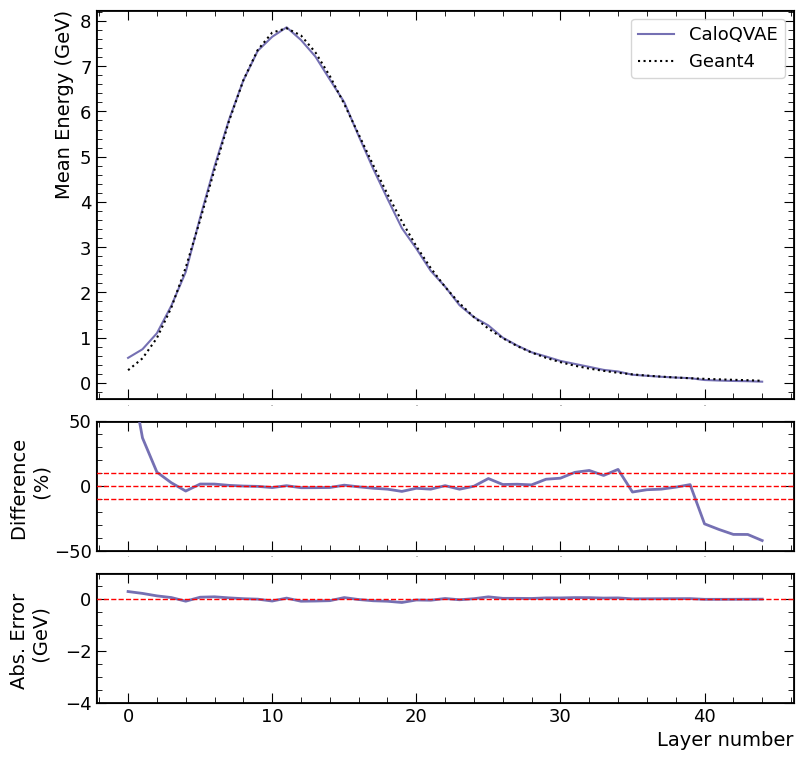

In [18]:
fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(3, 1, height_ratios=[3,1,1]) 
gs.update(wspace=0.025, hspace=0.1)

ax0 = plt.subplot(gs[0])
plt.xticks(fontsize=0)
ax1 = plt.subplot(gs[1],sharex=ax0)
plt.xticks(fontsize=0)
ax2 = plt.subplot(gs[2],sharex=ax0)

plot_label = 'CaloQVAE'
atlas_label = 'Geant4'

ax0.plot(layer_avg_data,label=plot_label,linestyle='-',color='#7570b3')
ax0.plot(layer_avg_atlas_data,label=atlas_label,linestyle='dotted',color='black')

ratio = 100*np.divide(layer_avg_data-layer_avg_atlas_data,layer_avg_atlas_data)
ax1.plot(ratio,color='#7570b3',linewidth=2,linestyle='-')
ax2.plot(layer_avg_data-layer_avg_atlas_data,color='#7570b3',linewidth=2,linestyle='-')

ax0.set_xlabel("",fontsize=20)
ax0.set_ylabel("Mean Energy (GeV)", fontsize=14, loc="top")

ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())

ax0.tick_params(which='both', direction="in")
ax0.tick_params(which='major', length=7, direction="in")
ax0.tick_params(which='minor', length=4, direction="in")

ax0.xaxis.set_ticks_position('both')
ax0.yaxis.set_ticks_position('both')
ax0.tick_params(axis="x",direction="in")
ax0.tick_params(axis="y",direction="in")

# Get the axis limits
x_min, x_max = ax0.get_xlim()
y_min, y_max = ax0.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax0.add_patch(outer_rectangle)

ax0.legend(loc='best',fontsize=13,ncol=1)

ax1.set_ylabel('Difference \n (%)', fontsize=14, labelpad=1)
plt.xlabel("Layer number", fontsize=14, loc='right')
ax1.axhline(y=0.0, color='r', linestyle='--',linewidth=1)
ax1.axhline(y=10, color='r', linestyle='--',linewidth=1)
ax1.axhline(y=-10, color='r', linestyle='--',linewidth=1)
ax1.set_ylim([-50,50])
plt.rc("font", size=13)

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', direction="in")
ax1.tick_params(which='major', length=7, direction="in")
ax1.tick_params(which='minor', length=4, direction="in")

ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.tick_params(axis="x",direction="in")
ax1.tick_params(axis="y",direction="in")

# Get the axis limits
x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax1.add_patch(outer_rectangle)

# Axis 2

ax2.set_ylabel('Abs. Error \n (GeV)', fontsize=14, labelpad=10)
ax2.axhline(y=0.0, color='r', linestyle='--',linewidth=1)
ax2.set_ylim([-4,1])

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax2.tick_params(which='both', direction="in")
ax2.tick_params(which='major', length=7, direction="in")
ax2.tick_params(which='minor', length=4, direction="in")

ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
ax2.tick_params(axis="x",direction="in")
ax2.tick_params(axis="y",direction="in")

# Get the axis limits
x_min, x_max = ax2.get_xlim()
y_min, y_max = ax2.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax2.add_patch(outer_rectangle)

IndexError: index 3 is out of bounds for GridSpec with size 3

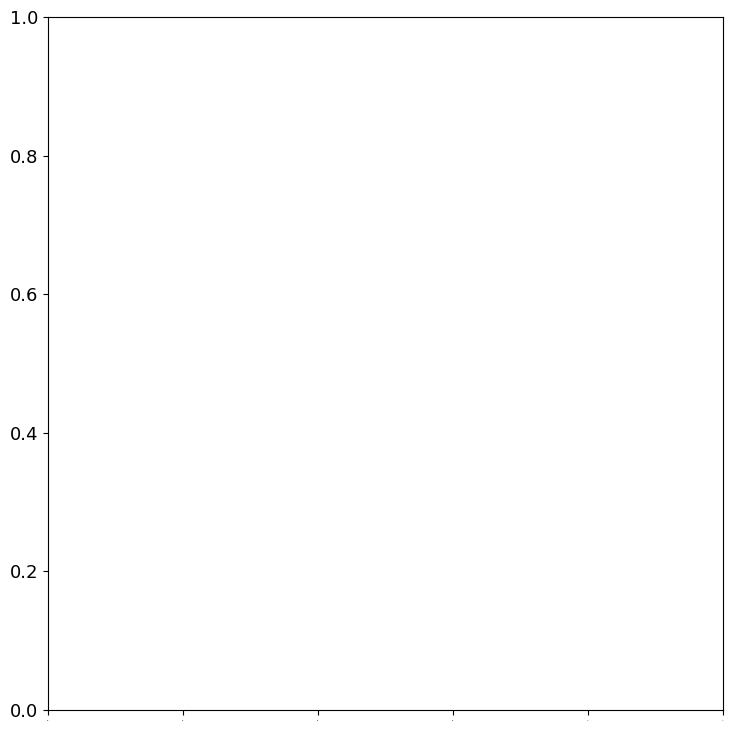

In [19]:
fig = plt.figure(figsize=(27, 9))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1]) 
gs.update(wspace=0.05, hspace=0.1)

# First graph
ax0 = plt.subplot(gs[0])
plt.xticks(fontsize=0)
ax1 = plt.subplot(gs[3], sharex=ax0)
plt.xticks(fontsize=0)
ax2 = plt.subplot(gs[6], sharex=ax0)

plot_label = 'CaloQVAE'
atlas_label = 'Geant4'

ax0.plot(r_avg_data, label=plot_label, linestyle='-', color='#7570b3')
ax0.plot(r_avg_atlas_data, label=atlas_label, linestyle='dotted', color='black')

ratio = 100 * np.divide(r_avg_data - r_avg_atlas_data, r_avg_atlas_data)
ax1.plot(ratio, color='#7570b3', linewidth=2, linestyle='-')
ax2.plot(r_avg_data - r_avg_atlas_data, color='#7570b3', linewidth=2, linestyle='-')

ax0.set_xlabel("", fontsize=20)
ax0.set_ylabel("Mean Energy (GeV)", fontsize=14, loc="top")

ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())

ax0.tick_params(which='both', direction="in")
ax0.tick_params(which='major', length=7, direction="in")
ax0.tick_params(which='minor', length=4, direction="in")

ax0.xaxis.set_ticks_position('both')
ax0.yaxis.set_ticks_position('both')
ax0.tick_params(axis="x", direction="in")
ax0.tick_params(axis="y", direction="in")

# Get the axis limits
x_min, x_max = ax0.get_xlim()
y_min, y_max = ax0.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax0.add_patch(outer_rectangle)

ax0.legend(loc='best', fontsize=13, ncol=1)

ax1.set_ylabel('Difference \n (%)', fontsize=14, labelpad=1)
plt.xlabel("r-bin", fontsize=14, loc='right')
ax1.axhline(y=0.0, color='r', linestyle='--', linewidth=1)
ax1.axhline(y=10, color='r', linestyle='--', linewidth=1)
ax1.axhline(y=-10, color='r', linestyle='--', linewidth=1)
ax1.set_ylim([-50, 50])
plt.rc("font", size=13)

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', direction="in")
ax1.tick_params(which='major', length=7, direction="in")
ax1.tick_params(which='minor', length=4, direction="in")

ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.tick_params(axis="x", direction="in")
ax1.tick_params(axis="y", direction="in")

# Get the axis limits
x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax1.add_patch(outer_rectangle)

# Axis 2
ax2.set_ylabel('Abs. Error \n (GeV)', fontsize=14, labelpad=10)
ax2.axhline(y=0.0, color='r', linestyle='--', linewidth=1)
ax2.set_ylim([-4, 1])

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax2.tick_params(which='both', direction="in")
ax2.tick_params(which='major', length=7, direction="in")
ax2.tick_params(which='minor', length=4, direction="in")

ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
ax2.tick_params(axis="x", direction="in")
ax2.tick_params(axis="y", direction="in")

# Get the axis limits
x_min, x_max = ax2.get_xlim()
y_min, y_max = ax2.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax2.add_patch(outer_rectangle)

# Second graph
ax0 = plt.subplot(gs[1])
plt.xticks(fontsize=0)
ax1 = plt.subplot(gs[4], sharex=ax0)
plt.xticks(fontsize=0)
ax2 = plt.subplot(gs[7], sharex=ax0)

plot_label = 'CaloQVAE'
atlas_label = 'Geant4'

ax0.plot(theta_avg_data, label=plot_label, linestyle='-', color='#7570b3')
ax0.plot(theta_avg_atlas_data, label=atlas_label, linestyle='dotted', color='black')

ratio = 100 * np.divide(theta_avg_data - theta_avg_atlas_data, theta_avg_atlas_data)
ax1.plot(ratio, color='#7570b3', linewidth=2, linestyle='-')
ax2.plot(theta_avg_data - theta_avg_atlas_data, color='#7570b3', linewidth=2, linestyle='-')

ax0.set_xlabel("", fontsize=20)
ax0.set_ylabel("Mean Energy (GeV)", fontsize=14, loc="top")

ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())

ax0.tick_params(which='both', direction="in")
ax0.tick_params(which='major', length=7, direction="in")
ax0.tick_params(which='minor', length=4, direction="in")

ax0.xaxis.set_ticks_position('both')
ax0.yaxis.set_ticks_position('both')
ax0.tick_params(axis="x", direction="in")
ax0.tick_params(axis="y", direction="in")

# Get the axis limits
x_min, x_max = ax0.get_xlim()
y_min, y_max = ax0.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax0.add_patch(outer_rectangle)

ax0.legend(loc='best', fontsize=13, ncol=1)

ax1.set_ylabel('Difference \n (%)', fontsize=14, labelpad=1)
plt.xlabel(r'$\theta$-bin', fontsize=14, loc='right')
ax1.axhline(y=0.0, color='r', linestyle='--', linewidth=1)
ax1.axhline(y=10, color='r', linestyle='--', linewidth=1)
ax1.axhline(y=-10, color='r', linestyle='--', linewidth=1)
ax1.set_ylim([-50, 50])
plt.rc("font", size=13)

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', direction="in")
ax1.tick_params(which='major', length=7, direction="in")
ax1.tick_params(which='minor', length=4, direction="in")

ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.tick_params(axis="x", direction="in")
ax1.tick_params(axis="y", direction="in")

# Get the axis limits
x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax1.add_patch(outer_rectangle)

# Axis 2
ax2.set_ylabel('Abs. Error \n (GeV)', fontsize=14, labelpad=10)
ax2.axhline(y=0.0, color='r', linestyle='--', linewidth=1)
ax2.set_ylim([-4, 1])

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax2.tick_params(which='both', direction="in")
ax2.tick_params(which='major', length=7, direction="in")
ax2.tick_params(which='minor', length=4, direction="in")

ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
ax2.tick_params(axis="x", direction="in")
ax2.tick_params(axis="y", direction="in")

# Get the axis limits
x_min, x_max = ax2.get_xlim()
y_min, y_max = ax2.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax2.add_patch(outer_rectangle)

# Third graph
ax0 = plt.subplot(gs[2])
plt.xticks(fontsize=0)
ax1 = plt.subplot(gs[5], sharex=ax0)
plt.xticks(fontsize=0)
ax2 = plt.subplot(gs[8], sharex=ax0)

plot_label = 'CaloQVAE'
atlas_label = 'Geant4'

ax0.plot(layer_avg_data, label=plot_label, linestyle='-', color='#7570b3')
ax0.plot(layer_avg_atlas_data, label=atlas_label, linestyle='dotted', color='black')

ratio = 100 * np.divide(layer_avg_data - layer_avg_atlas_data, layer_avg_atlas_data)
ax1.plot(ratio, color='#7570b3', linewidth=2, linestyle='-')
ax2.plot(layer_avg_data - layer_avg_atlas_data, color='#7570b3', linewidth=2, linestyle='-')

ax0.set_xlabel("", fontsize=20)
ax0.set_ylabel("Mean Energy (GeV)", fontsize=14, loc="top")

ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())

ax0.tick_params(which='both', direction="in")
ax0.tick_params(which='major', length=7, direction="in")
ax0.tick_params(which='minor', length=4, direction="in")

ax0.xaxis.set_ticks_position('both')
ax0.yaxis.set_ticks_position('both')
ax0.tick_params(axis="x", direction="in")
ax0.tick_params(axis="y", direction="in")

# Get the axis limits
x_min, x_max = ax0.get_xlim()
y_min, y_max = ax0.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax0.add_patch(outer_rectangle)

ax0.legend(loc='best', fontsize=13, ncol=1)

ax1.set_ylabel('Difference \n (%)', fontsize=14, labelpad=1)
plt.xlabel("Layer number", fontsize=14, loc='right')
ax1.axhline(y=0.0, color='r', linestyle='--', linewidth=1)
ax1.axhline(y=10, color='r', linestyle='--', linewidth=1)
ax1.axhline(y=-10, color='r', linestyle='--', linewidth=1)
ax1.set_ylim([-50, 50])
plt.rc("font", size=13)

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', direction="in")
ax1.tick_params(which='major', length=7, direction="in")
ax1.tick_params(which='minor', length=4, direction="in")

ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.tick_params(axis="x", direction="in")
ax1.tick_params(axis="y", direction="in")

# Get the axis limits
x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax1.add_patch(outer_rectangle)

# Axis 2
ax2.set_ylabel('Abs. Error \n (GeV)', fontsize=14, labelpad=10)
ax2.axhline(y=0.0, color='r', linestyle='--', linewidth=1)
ax2.set_ylim([-4, 1])

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax2.tick_params(which='both', direction="in")
ax2.tick_params(which='major', length=7, direction="in")
ax2.tick_params(which='minor', length=4, direction="in")

ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
ax2.tick_params(axis="x", direction="in")
ax2.tick_params(axis="y", direction="in")

# Get the axis limits
x_min, x_max = ax2.get_xlim()
y_min, y_max = ax2.get_ylim()

# Create a rectangle patch for the outer line
outer_rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='black', facecolor='none')
ax2.add_patch(outer_rectangle)

plt.show()
